<figure>
  <IMG SRC="https://raw.githubusercontent.com/fmeer/public-files/main/TUlogo.png" WIDTH=200 ALIGN="right">
</figure>

# Dynamic Stiffness Matrix method 
# (Python - Notebook 3.3 - student version)
    

### Task: 
#### Modify this notebook accordingly to obtain the steady-state response of systems subjected to harmonic loads with the same spatial distributions as the static ones. You will need to study and modify the element class accordingly to include the dynamic-related matrices and functions. You are adviced to study also the MAPLE files distributed in L3.1.1 for the derivations.

#### Check also the limit case: \begin{equation*} \omega=0 \end{equation*}

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## The Node class
The `Node` class from last week is pasted here for convenience and without changes.

**The code below does not need any modification**.

In [2]:
class Node:
    ndof = 0
    nn   = 0
    
    def clear():
        Node.ndof = 0
        Node.nn = 0
        
    def __init__ (self, x, y):  
        self.x     = x
        self.y     = y
        self.p     = np.zeros(3, dtype=complex)

        self.dofs  = [Node.ndof, Node.ndof+1, Node.ndof+2]

        Node.ndof += 3
        Node.nn   += 1

    def add_load (self, p):  
        self.p += p

## The Element class

Copy/paste your `Element` class from last week in the code block below. Use it as a basis for the changes you should make in this notebook.

**The code below is incomplete:**
- Code a function with header `def add_distributed_load ( self, q ):` that computes the equivalent load vector for a **constant load** $q$ and moves those loads to the nodes belonging to the element. Remember to use the `add_load` function of the `Node` class to store the equivalent loads (remember we have **two** nodes per element!). Also keep local/global transformations in mind and store `self.q = q` for later use;
- Code a function with header `def bending_moments ( self, u_global, num_points=2 ):` that receives the nodal displacements of the element in the global coordinate system (`u_global`) and uses it to compute the value of the bending moment at `num_points` equally-spaced points along the element length. Keep local/global transformations in mind and use the ODE approach in Maple to compute an expression for M (here you will need the `self.q` you stored before). You will also need a `np.linspace()` to get your range of points.

In [3]:
class Element:
    ne = 0

    def clear():
        Element.ne = 0
        
    def __init__ (self, nodes):
        self.nodes = nodes

        self.L = np.sqrt((nodes[1].x - nodes[0].x)**2.0 + (nodes[1].y - nodes[0].y)**2.0)

        dx = nodes[1].x - nodes[0].x
        dy = nodes[1].y - nodes[0].y

        self.cos = dx / self.L
        self.sin = dy / self.L

        R = np.zeros ((6,6))

        R[0,0] = R[1,1] = R[3,3] = R[4,4] = self.cos
        R[0,1] = R[3,4] = -self.sin
        R[1,0] = R[4,3] =  self.sin
        R[2,2] = R[5,5] = 1.0
        
        self.R  = R
        self.Rt = np.transpose(R)

        Element.ne += 1

    def set_section (self, props):
        if 'EA' in props:
            self.EA = props['EA']
        else:
            self.EA = 1.e20
        if 'EI' in props:
            self.EI = props['EI']
        else:
            self.EI = 1.e20

    def global_dofs  (self):
        return np.hstack ((self.nodes[0].dofs, self.nodes[1].dofs))

    def stiffness ( self ):
        k = np.zeros ((6, 6))

        EA = self.EA
        EI = self.EI
        L = self.L

        # Extension contribution

        k[0,0] = k[3,3] = EA/L
        k[3,0] = k[0,3] = -EA/L

        # Bending contribution

        k[1,1] = k[4,4] =  12.0 * EI / L / L / L
        k[1,4] = k[4,1] = -12.0 * EI / L / L / L
        k[1,2] = k[2,1] = k[1,5] = k[5,1] = -6.0 * EI / L / L
        k[2,4] = k[4,2] = k[4,5] = k[5,4] = 6.0 * EI / L / L
        k[2,2] = k[5,5] = 4.0 * EI / L
        k[2,5] = k[5,2] = 2.0 * EI / L

        return np.matmul ( np.matmul ( self.Rt, k ), self.R )

    def add_distributed_load ( self, q ):

        l = self.L

        self.q = np.array( q )

        el = [ 0.5*q[0]*l, 0.5*q[1]*l, -1.0/12.0*q[1]*l*l, 0.5*q[0]*l, 0.5*q[1]*l, 1.0/12.0*q[1]*l*l ]

        eg = np.matmul ( self.Rt, np.array ( el ) )

        self.nodes[0].add_load ( eg[0:3] )
        self.nodes[1].add_load ( eg[3:6] )
        
    def bending_moments ( self, u_global, num_points=2 ):
    
        l = self.L
        q = self.q[1]
        EI= self.EI

        xi = np.linspace ( 0.0, l, num_points )
        M  = np.zeros(num_points)

        ul = np.matmul ( self.R, u_global )

        M = ( -l**5.0*q + 6.0 * l**4.0*q*xi
              - 6.0*q*xi*xi*l**3.0 - 48.0*(ul[2] + ul[5]/2.0)*EI*l**2.0 
              + 72.0*EI*((ul[2]+ul[5])*xi+ul[1]-ul[4])*l - 144.0*xi*EI*(ul[1]-ul[4]) ) / 12.0 / l**3.0

        return M

## The Constrainer class

We give you a new `Constrainer` class here which now also stores possibly non-zero values for displacement boundary conditions. We also add funcionality to `fix_dof` to allow for a non-zero value and accommodate the functions we had before by calling the new one. Finally, we also added a new `full_disp` function that returns the full nodal displacement vector with `u_free` (computed by our solver) and `u_cons` (already known by `Constrainer`, i.e. the prescribed displacement values).

***The implementation below is incomplete***:
- Code the `constrain` function again, but this time taking into account non-zero Dirichlet BCs. Note that we now store `free_dofs` for later use.
- Code a new `support_reactions` functions to compute support reactions. Since the constrainer is always first going to get `constrain` called, here we already have access to `self.free_dofs`. Together with `self.cons_dofs`, you should have all you need to compute reactions. Note that `f` is also passed as argument. Make sure you take into account the contribution of equivalent element loads that go directly into the supports without deforming the structure.

In [4]:
class Constrainer:
    def __init__ (self):
        self.cons_dofs = []
        self.cons_vals = []

    def fix_dof (self, node, dof, value=0):
        self.cons_dofs.append(node.dofs[dof])
        self.cons_vals.append(value)
 
    def fix_node (self, node):
        for dof in node.dofs:
            self.fix_dof (node, dof)      

    def full_disp (self,u_free):
        u_full = np.zeros(len(self.free_dofs) + len(self.cons_dofs))
        
        u_full[self.free_dofs] = u_free
        u_full[self.cons_dofs] = self.cons_vals
        
        return u_full
    
    def constrain (self, k, f):
        self.free_dofs = [i for i in range(len(f)) if i not in self.cons_dofs]
        
        Kff = k[np.ix_(self.free_dofs,self.free_dofs)]
        Kfc = k[np.ix_(self.free_dofs,self.cons_dofs)]
        Ff = f[self.free_dofs]

        return Kff, Ff - np.matmul(Kfc,self.cons_vals)
    
    def support_reactions (self,k,u_free,f):       
        Kcf = k[np.ix_(self.cons_dofs,self.free_dofs)]
        Kcc = k[np.ix_(self.cons_dofs,self.cons_dofs)]
        
        return np.matmul(Kcf,u_free) + np.matmul(Kcc,self.cons_vals) - f[self.cons_dofs]

## Sanity check: Beam with distributed load

Having made your implementations, it is now time to verify your code with a simple sanity check. Here we would like to solve the following simply-supported beam:
<figure>
  <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/ssbeam.png" WIDTH=200 ALIGN="center">
</figure>

Use the code blocks below to set up and solve this problem using the classes above. As before, we give you some code blocks to organize your solution. Once you are done, compare the rotation at the right end of the beam and the bending moment at midspan to the solution you obtained in the first half of the course:

$$
\varphi(\ell) = \frac{q\ell^3}{24EI}
\quad
M(\ell/2) = \frac{q\ell^2}{8}
$$

### Parameters

We define the parameters here for convenience. We also use the `clear` functions to restart the node, element and DOF counters. Make sure this is done whenever you start solving a new problem.

In [5]:
EI = 1000
q  = 10
L  = 1

Node.clear()
Element.clear()

### Create nodes

In [6]:
node1 = Node (0,0)
node2 = Node (L,0)

### Create element

In [7]:
elem = Element ( [node1, node2] )

section = {}
section['EI'] = EI

elem.set_section (section)

### Set boundary conditions

The new thing here is to also add the distributed load $q$ to your element. For that, use the new function you implemented in `Element`.

In [8]:
con = Constrainer()

con.fix_dof (node1,0)
con.fix_dof (node1,1)
con.fix_dof (node2,1)

elem.add_distributed_load([0,10])

### Assemble the system of equations

In [9]:
global_k = elem.stiffness()
global_f = np.zeros (6)

global_f[0:3] = node1.p
global_f[3:6] = node2.p

### Constrain the problem and solve for nodal displacements

In [10]:
Kc, Fc = con.constrain ( global_k, global_f )
u_free = np.matmul ( np.linalg.inv(Kc), Fc )
print(u_free)

[-0.00041667  0.          0.00041667]


### Support reactions

Here you should call the new function you coded in `Constrainer`

In [11]:
print(con.support_reactions(global_k,u_free,global_f))

[ 0. -5. -5.]


### Moment distribution

Use this block to plot the moment distribution along the element and to get its value at midspan. Use the new `bending_moments` function you implemented in `Element` and `matplotlib` to plot your moment line. 

Note that `bending_moments` expects a full element displacement vector with 6 entries, while our solver only computes `u_free`. We therefore use the new `full_disp` function of `Constrainer` to fill in the gaps for us.

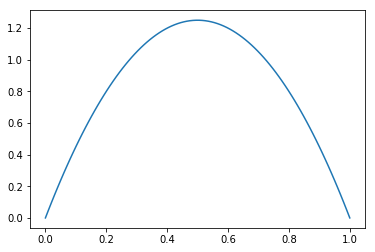

In [12]:
u_elem = con.full_disp(u_free)[elem.global_dofs()]

moments = elem.bending_moments(u_elem,100)
plt.plot(np.linspace(0,L,100),moments)

### Compare with the solution you know

Finally, compare the rotation at the end of the beam and the moment at midspan with the analytical solutions you already know.

In [13]:
print('ODE solution',q*L*L*L/24/EI,'Matrix method solution',u_free[2])

ODE solution 0.0004166666666666667 Matrix method solution 0.0004166666666666666


In [14]:
print('ODE moment at midspan',q*L*L/8,'Matrix method result',elem.bending_moments(u_elem,3)[1])

ODE moment at midspan 1.25 Matrix method result 1.2499999999999998


Did your solutions match? If so, that is a sign your implementation is correct.

# Final example: Two-element frame

<figure>
  <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/twoelemframe.png" WIDTH=300 ALIGN="center">
</figure>
    
The final example of this notebook is the two-element frame above. Here you should make use of all the new code you implemented:
    
- Set up the problem and compute a solution for `u_free`. Remember to consider the prescribed horizontal displacement $\bar{u}$ at the right end of the structure.
- Compute and plot bending moment lines for both elements (in their local coordinate systems)
- Compute reactions at both supports
    
You can use the parameters given below. 

### Parameters

In [15]:
EI = 1500
EA = 1000
q = 9
L = 5
phibar = 0.15

Node.clear()
Element.clear()

### Create nodes

In [16]:
nodes = []

nodes.append(Node(0,0))
nodes.append(Node(L,L))
nodes.append(Node(2*L,0))

### Create elements

In [17]:
elems = []

elems.append(Element([nodes[0], nodes[1]]))
elems.append(Element([nodes[1], nodes[2]]))

section = {}
section['EI'] = EI
section['EA'] = EA

for elem in elems:
    elem.set_section(section)

### Set boundary conditions

In [18]:
con = Constrainer()

con.fix_dof (nodes[0], 0)
con.fix_dof (nodes[0], 1)
con.fix_dof (nodes[2], 0)
con.fix_dof (nodes[2], 1)
con.fix_dof (nodes[2], 2, phibar)

elems[0].add_distributed_load([0,q])
elems[1].add_distributed_load([0,2*q])

### Assemble the system

In [19]:
global_k = np.zeros ((3*len(nodes), 3*len(nodes)))
global_f = np.zeros (3*len(nodes))

for e in elems:
    elmat = e.stiffness()
    idofs = e.global_dofs()
    
    global_k[np.ix_(idofs,idofs)] += elmat

for n in nodes:
    global_f[n.dofs] += n.p

### Constrain the problem and solve for nodal displacements

In [20]:
Kc, Fc = con.constrain ( global_k, global_f )
u_free = np.matmul ( np.linalg.inv(Kc), Fc )
print(u_free)

[-0.09274451 -0.13310939  0.51159348 -0.01644455]


### Support reactions

In [21]:
print(con.support_reactions(global_k,u_free,global_f))

[ 27.35024439 -63.82451092  17.64975561 -71.17548908 -36.75489076]


### Moment lines

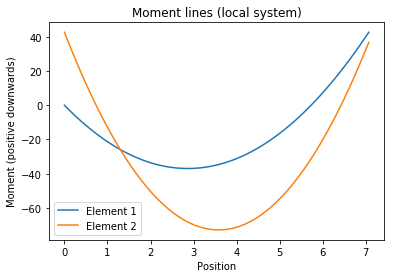

In [22]:
u_full = con.full_disp(u_free)
for i,elem in enumerate(elems):
    u_elem = u_full[elem.global_dofs()]
    x = np.linspace(0,elem.L,100)
    y = elem.bending_moments(u_elem,100)
    plt.title('Moment lines (local system)')
    plt.xlabel('Position')
    plt.ylabel('Moment (positive downwards)')
    plt.plot(x,-y,label='Element '+str(i+1))
    plt.legend()
    plt.savefig('moments.png')